# Checkpoint 2
### Due: Tuesday, 8 November, 2022 at 11:00am BST

### Total points: 100

### Read This First

Wherever you see raise NotImplementedError(), remove that line and put your code there.

Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc.

Your notebook must run correctly when executed once from start to finish. Your notebook will be graded based on how it runs, not how it looks when you submit it. To test this, go to the Kernel menu and select Restart & Run All.

Once you are happy with it, clear the output by selecting Restart & Clear Output from the Kernel menu.

You should aim for your code to not take more than around a minute per task. 

Submit through Noteable.

# Task 1 (20 points)

The first task is to find the number of local minima of the function. 
The function is defined in any number of dimensions. 

And your job is to function the number of local minimima of the function for dimensions 1, 2 3, 4, 5. Your code should return the list or array of 5 integer values.

The number of local minima for ndim = 1 should be 4. All the minimima should be within -10..10 range

We also know that the function has no minima separated by less than 0.01.

In [1]:
import numpy as np
import scipy.optimize
import scipy.linalg
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [2]:
import scipy.optimize as scopt

In [3]:
T1_D = np.load('ch2_task1.npz')['D']
dims = [1, 2, 3, 4, 5]
import scipy.special as ssp

def blackbox_func(p):
    """
    This is is the function that you need to optimize
    DO NOT CHANGE THE CODE INSIDE THIS FUNCTION
    """
    p = np.asarray(p)
    ndim = len(p)
    pos = dims.index(ndim)
    curD = T1_D[10000 * pos:10000 * (pos + 1), :ndim]
    return -ssp.logsumexp(np.sum(-0.5 * ((p[None, :] - curD) / .3)**2, axis=1))

# The function is defined in  1,2,3,4,5 dimensions
print (blackbox_func([0]))
print (blackbox_func([0,0]))
print (blackbox_func([0,0,0]))


-1.5339371748888972
155.5936341672975
80.92394156884913


In [4]:
def find_nminima():
    
    """
    
    This function calculates the number of local minima of the blackbox function for dimensions 1 to 5. It does this by
    using the Nelder-Mead optimizer with random initial guesses N times and storing the local minima. Repeats are then 
    removed using the np.unique function to find the number of unique local minima. 
    
    Returns:
    
    list with the number of local minima of blackbox function for dimensions 1 to 5
    
    """
    n_minima = []
    
    for n in range(1,6):
    
        minima = np.array([np.ones(n)*11])
        
        N = 50
        
        for i in range(N):
            
            #Rounds the values to 2 decimal places as we know that the minima are at separated by at least 0.01 
            res = np.around(scopt.minimize(blackbox_func, np.random.uniform(-10,10, n), method='Nelder-Mead', tol = 1e-5).x, 2)
            res_array = np.array([res])
            minima = np.append(minima, res_array, axis = 0)
    
        minima = np.unique(minima, axis = 0)
        n_minima.append(len(minima) - 1)
    
    
    return n_minima

In [5]:
my_minima = find_nminima()
assert len(my_minima) == 5
assert (my_minima[0]) == 4


# Task 2 (20 pts)

Generate random numbers from a probability distribution that looks like two triangles. 
The PDF f(x) is the following. Use the inverse CDF sampling method.
* f(x) = 0 when x<0
* f(x)= x/2 when 0<x<=1
* f(x)= 1-x/2 when 1<x<=2
* f(x)= 0 when 2<x<=3
* f(x)= (x-3)/2 when 3<x<4
* f(x)= (5-x)/2 when 4<x<5
* f(x)= 0 when x>=5


In [6]:
def generate_triangles(N):
    
    """ Return a numpy array with the length N with 
    random numbers following the distribution specified
    """
    
    
    ys = np.random.uniform(size = N)
    xs = ys*0

    #CDF and inverse CDF calculated analytically
    xs[(ys > 0) & (ys <= 0.25)] = 2*np.sqrt(ys[(ys >= 0) & (ys < 0.25)])

    xs[(ys > 0.25) & (ys <= 0.5)] = 2 - np.sqrt(2 - 4*ys[(ys > 0.25) & (ys < 0.5)])

    xs[(ys > 0.5) & (ys <= 0.75)] = 3 + np.sqrt(4*ys[(ys > 0.5) & (ys < 0.75)] - 2)

    xs[(ys > 0.75) & (ys < 1)] = 5 - 2*np.sqrt(1 - ys[(ys > 0.75) & (ys < 1)])
    
    
    return xs

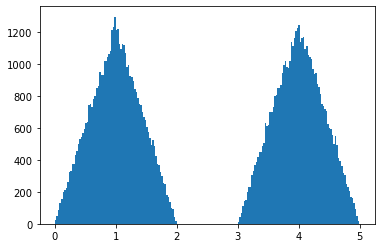

In [7]:
# The code will be tested by this 
# the distribution of points should look like two triangles
plt.hist(generate_triangles(100000), bins=200);

# Task 3 (20 pts)

The motion of bodies in the Solar system can be described by the Kepler equation 
$$2 \pi t/T = E - e \sin(E)$$
where e is orbit eccentricity, t is the time of observation, T is the orbital period. And E is the so-called eccentric anomaly. 
If you know the eccentric anomaly E (by solving numerically the previous equation) then the position of the body in the plane of the solar system can be described by 
$$x= a  (\cos E -e) $$
$$y= b \sin E $$
where a, b are the semi-major axis and semi-minor axis respectively.

Your task is to write the function that determines the uncertainty on the position x given the time of observation (t), ecentricity (e), period (T), semi-major axis (a) and their uncertainties.
You can assume that the eccentric anomaly E will be always between -1000 and 1000.
We will verify that the errors are accurate to within 10%

In [8]:
def func_for_E(E, t, T, e):
    
    """
    Function required for Brents method of root finding where E is the variable and the rest of the values
    are paramaters
    """
    
    return E - e*np.sin(E) - (2*np.pi*t)/(T)

In [9]:
def kepler_uncert(t=None, T=None, e=None, a=None, err_t=None, err_T=None, err_e=None, err_a=None):
    
    """
    Returns the value of the uncertainty on the x position of the solar system body. This is done by sampling the variables
    from normal distributions with mean and width specified. Brents method was then used to create a random distribution
    of eccentric anomalies which then allowed the error on x to be estimated. N is kept large to smooth over randomness
    """
    
    N = 1000000
    
    ts = np.random.normal(t, err_t, size=N)
    Ts = np.random.normal(T, err_T, size=N)
    es = np.random.normal(e, err_e, size=N)
    As = np.random.normal(a, err_a, size=N)
    

    Es = np.zeros(N)
    
    for i in range(N):
        
        E = scopt.brentq(func_for_E, -1000, 1000, args = (ts[i], Ts[i], es[i]))
        Es[i] = E
    
    x = As*(np.cos(Es) - es)
    
    
    return np.std(x)

In [10]:
print(kepler_uncert(t=1, T=2, e=.5, a=3, err_t=1e-5, err_T=1e-4, err_e=1e-1, err_a=0.01))
# This value should be close to 0.015

print(kepler_uncert(t=3, T=4, e=.4, a=6, err_t=1e-4, err_T=1e-3, err_e=1e-2, err_a=0.02))
# This should be close to 0.106


0.3007071461822003
0.10668203940336526


In [11]:
print(kepler_uncert(t=1, T=2, e=.5, a=3, err_t=1e-5, err_T=1e-4, err_e=1e-3, err_a=0.01))
# This value should be close to 0.015

print(kepler_uncert(t=3, T=4, e=.4, a=6, err_t=1e-4, err_T=1e-3, err_e=1e-2, err_a=0.02))
# This should be close to 0.106

0.015288336491108096
0.10675576842133418


# Task 4 (20 pts)

# Fitting a periodic model to the data. 

In the input data ch2_task4.txt. we have repeated measurements from the instrument. 
The file has 3 columns. One is the time of observation, the second one is the measurement, and the third one is the uncertainty of the measurement. 
We have reasons to believe that the measurement periodically change with time, so we want to fit the dataset provided by a periodic model 
$$M(x) = A \sin(2\pi x/T) + B \cos(2\pi x/T) $$
in order to determine the period T from the data. A,B,T are model parameters

Assuming that we know that the period should be between 0.5 and 5, determine the best period describing the data with the accuracy of better than 0.1.

Your function needs to return the tuple with the best period and bestmodel values

Hint: Use linear regression to fit the periodic models for a grid of periods. Select the period providing the best fit.

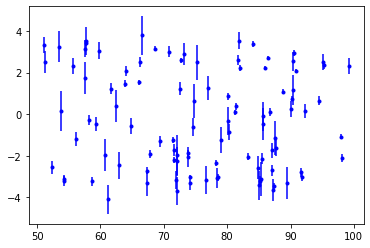

In [12]:
#Reads in the data
T4_DATA = np.loadtxt('ch2_task4.txt')

#Makes a plot of data with error bars
plt.errorbar(T4_DATA[0], T4_DATA[1], T4_DATA[2], fmt='.', color = 'b')


def findper():
    
    """
    
    This function uses a linear regression method to find the best model to describe the data by fitting a period function.
    A loop is done over a large number of values of the period and then a least squares method is used to determine the 
    best parameters for each period. 
    
    The function returns the best model that minimises chi squared
    
    """
    
    
    X = T4_DATA[0]
    Y = T4_DATA[1]
    E = T4_DATA[2]
    
    
    iterations = 100000
    
    Ts = np.linspace(0.5, 5, iterations)
    N = len(X)
        
    Results = np.zeros((iterations,4))
    
    for T in Ts:
        
        i = np.where(Ts == T)
        
        A = np.zeros((N,2))
        A[:, 0] = np.sin(2*np.pi*X/T)/E
        A[:, 1] = np.cos(2*np.pi*X/T)/E
    
        res = scipy.linalg.lstsq(A, Y / E)
    
        param = res[0]
        chisq = res[1]
    
        Results[i, 0] = T
        Results[i, 1] = chisq
        Results[i, 2] = param[0]
        Results[i, 3] = param[1]
    
    min_index = np.argmin(Results[:,1])
    BestModel = Results[min_index]
    
    bestp = BestModel[0]
    bestA = BestModel[2]
    bestB = BestModel[3]
    
    Y_best = bestA * np.sin(2*np.pi*X/bestp) + bestB * np.cos(2*np.pi*X/bestp)
    
    return bestp, Y_best


BEST PERIOD 2.2010170101701014


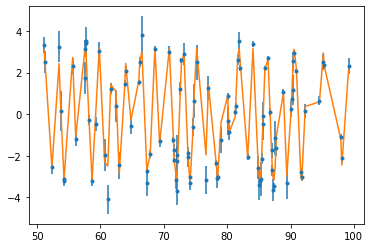

In [13]:
# Your code will be tested with this 
plt.errorbar(T4_DATA[0], T4_DATA[1], T4_DATA[2], fmt='.')
bestp, bestmod = findper()
print('BEST PERIOD', bestp)
plt.plot(np.sort(T4_DATA[0]), bestmod[np.argsort(T4_DATA[0])])


# Task 5 (20 pts)

You are given a dataset from the particle physics experiment. 
In that experiment the number of particles are recorded in intervals of Energy.
The dataset contains the array of those numbers and the center Energy of each bin/interval. 
We believe that the average number of particles in each bin could be described by  this model 
$$R(E) = A_1+ A_2 \exp(A_3  E) + A_4  \exp
\left( - \frac{1}{2}\frac{(E-A_5)^2}{A_6^2} \right)$$

where the first two terms are describing the background and the last term is a contribution from a decaying 
particle with the mean energy A5. This contribution creates a peak in the energy distribution. Your task is to measure A5.

In the dataset you can assume that the number of particles in each bin is described by Poisson distribution with the rate described by the equantion above. You can assume that measurement of number of particles in each bin are independent from each other.

Write the likelihood function and estimate the energy of the particle $A_5$ using maximum likelihood approach. 
Overplot your best model on top of the data and make sure it fits well. 

Determine the uncertainty of your measurement. Your function solve_task5() should return two numbers
the estimate of the energy and its uncertainty. (If you don't know how to evaluate uncertainty, you can just return np.nan instead)

Text(0, 0.5, 'Number of particles')

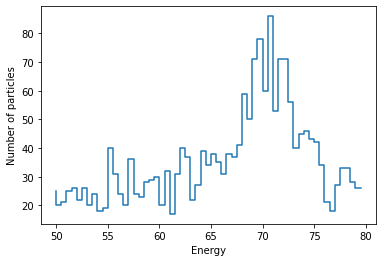

In [14]:
T5_DATA = np.loadtxt('ch2_task5.txt', dtype=[('E', np.float64), ('N', int)])
T5_DATA['E']
T5_DATA['N']
plt.plot(T5_DATA['E'], T5_DATA['N'], drawstyle='steps')
plt.xlabel('Energy')
plt.ylabel('Number of particles')

In [15]:
def like(p, E, N):
    
    
    """
    Function that determines the negative log of the likelihood
    """
    
    
    A1, A2, A3, A4, A5, A6 = p
    
    rate = A1 + A2 * np.exp(A3 * E) + A4 * np.exp(-((0.5)/(A6**2)) * (E - A5)**2)
    P = scipy.stats.poisson(rate)
    logp = np.log(P.pmf(N)).sum()
    
    
    return -logp

In [16]:
def fitting(X, p):
    
    """
    Fitting of the data
    """
    
    A1, A2, A3, A4, A5, A6 = p
    
    rate = A1 + A2 * np.exp(A3 * X) + A4 * np.exp(-((0.5)/(A6**2)) * (X - A5)**2)
    
    return rate

In [17]:
def solve_task5():
    
    """
    This function minimises the negative log likelihood in order to determine the best model to describe the data
    It returns a plot of the data and fit as well as the value A5 with calculated error. 
    """
    
    E = T5_DATA['E']
    N = T5_DATA['N']


    #The BFGS method was used as it provides an estimate of the hessian matrix
    #From this, the errors could be estimated
    #Initial guess was chosen by comparing the fit with data visually as well as trying to reduce the errors of the parameters
    ret = scipy.optimize.minimize(like, [15, -2, -2, 40, 60, 3], args=(E, N,), method = 'BFGS')

    plt.plot(E, N, drawstyle='steps', color = 'magenta')
    plt.xlabel('Energy')
    plt.ylabel('Number of particles')

    plt.plot(E, fitting(E, ret['x']), color = 'blue')

    A5_best = ret['x'][4]

    A5_best_error = np.sqrt(np.diag(ret['hess_inv']))[4]
    
    return A5_best, A5_best_error 

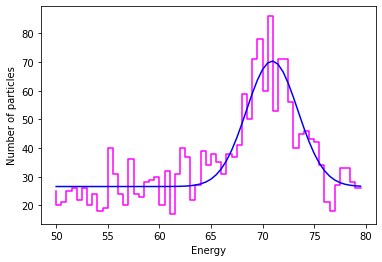

In [18]:
bestval, bessterr = solve_task5()



In [19]:
print (bestval)
print (bessterr)

70.93548363694623
0.19260341368587236
